# Import Liberaries

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install virtualenv

In [ ]:
# !virtualenv /content/drive/MyDrive/colab_env

In [3]:
# !source /content/drive/MyDrive/colab_env/bin/activate; pip install netCDF4 geopandas pyet rasterio wxee geemap rioxarray rasterio virtualenv
!source /content/drive/MyDrive/colab_env/bin/activate

In [6]:
import os
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import pyet
import pickle
import pyproj
import ee
import wxee
import geemap
import itertools
import rasterio
from osgeo import gdal
import rioxarray
import dask


sys.path.append('/content/drive/MyDrive/WaterBalance_new')

from qdwb.evapotranspiration.et import *
from qdwb.evapotranspiration.asset import *
from qdwb.evapotranspiration.convert import *
from qdwb.coordinate.extract import *
from qdwb.primary_surface_flow.primary_surface_flow import *
from qdwb.primary_surface_flow.asset import *
from qdwb.soil_content.soil import *

## Authorize in Google Earth Engine

In [7]:
service_account = 'test-175@ee-mohammadnejadmehdi77.iam.gserviceaccount.com'

credentials = ee.ServiceAccountCredentials(
    email=service_account,
    key_file='/content/drive/MyDrive/private-key.json'
)

ee.Initialize(credentials)

# Variables

In [8]:
PATH_DATA = "/content/drive/MyDrive/WaterBalance_new/assets"

# mashhad
LAT_MIN = 35.80
LAT_MAX = 37.11
LON_MIN = 58.31
LON_MAX = 60.14

# USA
# LAT_MIN = 43.30
# LAT_MAX = 44.60
# LON_MIN = -109.40
# LON_MAX = -107.40

# Functions

In [9]:
def mask_nc_file(
    nc,
    variable,
    lat_min,
    lat_max,
    lon_min,
    lon_max
):
    with xr.open_dataset(nc) as xr_nc:
        result = xr_nc.sel(
            lat = slice(lat_max, lat_min),
            lon = slice(lon_min, lon_max),
        )
    return result

In [10]:
import datetime

# Define the start and end dates of your time series
start_date = datetime.date(2020, 1, 31)
end_date = datetime.date(2022, 2, 2)

# Generate the time series of dates
date_range = [start_date + datetime.timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Convert each date to the TIMESTAMP-like format
timestamp_series = [date.strftime("%Y%j") for date in date_range]
list_time = []
# Print the generated TIMESTAMP series
for timestamp in timestamp_series:
    list_time.append(int(timestamp))

In [11]:
list_dir = []
for date in list_time:
    list_dir.append(f'/content/drive/MyDrive/MSWX_V100/Past/P/Daily/{date}.nc')

In [37]:

datasets = [xr.open_dataset(file) for file in list_dir]


merged_dataset = xr.merge(datasets)
merged_dataset

<xarray.Dataset>
Dimensions:        (lon: 3600, lat: 1800, time: 3)
Coordinates:
  * lon            (lon) float32 -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
  * lat            (lat) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time           (time) datetime64[ns] 2022-01-31 2022-02-01 2022-02-02
Data variables:
    precipitation  (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

In [15]:
from netCDF4 import Dataset
dataset = nc.MFDataset(list_dir)
dataset

ValueError: ignored

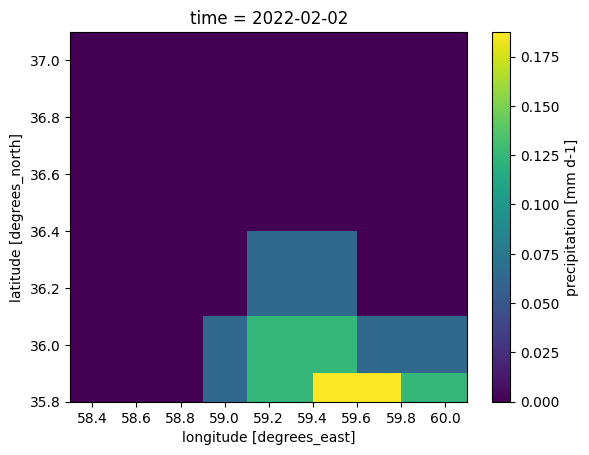

In [19]:
selected_data = merged_dataset.sel(time='2022-02-02')
selected_data.precipitation.plot()

# Load Data

In [16]:
# degree_Celsius - Max air temperature
tmax = mask_nc_file(
    nc = PATH_DATA + "/nc/Tmax_2022031.nc",
    variable = "air_temperature",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# degree_Celsius - Min air temperature
tmin = mask_nc_file(
    nc = PATH_DATA + "/nc/Tmin_2022031.nc",
    variable = "air_temperature",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# degree_Celsius - Mean air temperature
tmean = mask_nc_file(
    nc = PATH_DATA + "/nc/Temp_2022031.nc",
    variable = "air_temperature",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# m s-1 - wind_speed
wind = mask_nc_file(
    nc = PATH_DATA + "/nc/wind_2022031.nc",
    variable = "wind_speed",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# W m-2 - downward_shortwave_radiation
Rns = mask_nc_file(
    nc = PATH_DATA + "/nc/SWd_2022031.nc",
    variable = "downward_shortwave_radiation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# kg kg-1 - specific_humidity
specific_humidity = mask_nc_file(
    nc = PATH_DATA + "/nc/SpecHum_2022031.nc",
    variable = "specific_humidity",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# Pa - surface_pressure
surface_pressure = mask_nc_file(
    nc = PATH_DATA + "/nc/Pres_2022031.nc",
    variable = "surface_pressure",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# mm d-1 - precipitation
P = mask_nc_file(
    nc = PATH_DATA + "/nc/P_2022031.nc",
    variable = "precipitation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
# W m-2 - downward_longwave_radiation
Rnl = mask_nc_file(
    nc = PATH_DATA + "/nc/LWd_2022031.nc",
    variable = "downward_longwave_radiation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)

usa = gpd.read_file(PATH_DATA + "/shape/usa.shp")
mashhad = gpd.read_file(PATH_DATA + "/shape/mahdoode_mashhad.shp")

Exception ignored in: <function CachingFileManager.__del__ at 0x7f96104af520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xarray/backends/file_manager.py", line 242, in __del__
    ref_count = self._ref_counter.decrement(self._key)
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'
Exception ignored in: <function CachingFileManager.__del__ at 0x7f96104af520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xarray/backends/file_manager.py", line 242, in __del__
    ref_count = self._ref_counter.decrement(self._key)
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'


# initial soil moisture

In [17]:
crs = 4326
shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])


soil_era_evaporation = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filter(ee.Filter.date('2022-01-31', '2022-02-01')).select('volumetric_soil_water_layer_1').mean().clip(shape)

soil_era_transpiration = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filter(ee.Filter.date('2022-01-31', '2022-02-01')).select('volumetric_soil_water_layer_3').mean().clip(shape)

soil_era_transition = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filter(ee.Filter.date('2022-01-31', '2022-02-01')).select('volumetric_soil_water_layer_4').mean().clip(shape)


soil_era_evaporation = soil_era_evaporation.set("system:time_start", ee.Date("2022-01-31"))
soil_era_transpiration = soil_era_transpiration.set("system:time_start", ee.Date("2022-01-31"))
soil_era_transition = soil_era_transition.set("system:time_start", ee.Date("2022-01-31"))


arr_soil_era_evaporation = soil_era_evaporation.wx.to_xarray(scale=11132, crs=f'EPSG:{crs}')
arr_soil_era_transpiration = soil_era_transpiration.wx.to_xarray(scale=11132, crs=f'EPSG:{crs}')
arr_soil_era_transition = soil_era_transition.wx.to_xarray(scale=11132, crs=f'EPSG:{crs}')

da_soil_era_evaporation = arr_soil_era_evaporation.rio.write_crs(f"epsg:{crs}", inplace=True)
da_soil_era_transpiration = arr_soil_era_transpiration.rio.write_crs(f"epsg:{crs}", inplace=True)
da_soil_era_transition = arr_soil_era_transition.rio.write_crs(f"epsg:{crs}", inplace=True)

tmin_renamed = tmin.rename({'lon': 'x','lat': 'y'})
tmin_renamed = tmin_renamed.rio.write_crs(f"epsg:{crs}", inplace=True)


xds_repr_match__soil_era_evaporation = da_soil_era_evaporation.rio.reproject_match(tmin_renamed, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__soil_era_transpiration = da_soil_era_transpiration.rio.reproject_match(tmin_renamed, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__soil_era_transition = da_soil_era_transition.rio.reproject_match(tmin_renamed, resampling = rasterio.enums.Resampling.nearest)


xds_repr_match__soil_era_evaporation = xds_repr_match__soil_era_evaporation * (70-0)
xds_repr_match__soil_era_transpiration = xds_repr_match__soil_era_transpiration * (1000 - 280)
xds_repr_match__soil_era_transition = xds_repr_match__soil_era_transition * (2890-1000)



Downloading:   0%|          | 0.00/2.38k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/2.32k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/2.27k [00:00<?, ?iB/s]

# Estimate persent of soil properties like sand, clay and organic

In [18]:
# Soil depths [in cm] where we have data.
olm_depths = [0, 10, 30, 60, 100, 200]

# Names of bands associated with reference depths.
olm_bands = ["b" + str(sd) for sd in olm_depths]

def get_soil_prop(param):
    """
    This function returns soil properties image
    param (str): must be one of:
        "sand"     - Sand fraction
        "clay"     - Clay fraction
        "orgc"     - Organic Carbon fraction
    """
    if param == "sand":  # Sand fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "clay":  # Clay fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "orgc":  # Organic Carbon fraction [g/kg]
        snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 5 * 0.001  # to get kg/kg
    else:
        return print("error")

    # Apply the scale factor to the ee.Image.
    dataset = ee.Image(snippet).multiply(scale_factor)

    return dataset


# Image associated with the sand content.
sand = get_soil_prop("sand")

# Image associated with the clay content.
clay = get_soil_prop("clay")

# Image associated with the organic carbon content.
orgc = get_soil_prop("orgc")


# Generate Grid and lat and lon list

In [19]:
lat_of_points = list(tmin.lat.values.flatten())
lon_of_points = list(tmin.lon.values.flatten())

grid = [(float(i), float(j)) for i, j in itertools.product(lon_of_points, lat_of_points)]
x_values = [t[0] for t in grid]
y_values = [t[1] for t in grid]

## estimate organic material

In [20]:
# scale of original data such as tmin and precipitation
scale = 12128.507

def local_profile(dataset, points, buffer):
  """Gets the properties of a list of points.

  Args:
    dataset: The Earth Engine dataset to query.
    points: A list of points.
    buffer: The buffer size to use when sampling the dataset.

  Returns:
    A list of dictionaries, where each dictionary contains the properties of a point.
  """

  profiles = []
  for point in points:
    poi = ee.Geometry.Point(point[0], point[1])
    prop = dataset.sample(poi, buffer).select(olm_bands).getInfo()
    profile = prop["features"][0]["properties"]
    profile = {key: round(val, 3) for key, val in profile.items()}
    profiles.append(profile)

  return profiles

orgm = orgc.multiply(1.724)
point = list(zip(x_values, y_values))

list_org = local_profile(
    dataset = orgm,
    points = point,
    buffer = scale
)
list_sand = local_profile(
    dataset = sand,
    points = point,
    buffer = scale
)
list_clay = local_profile(
    dataset = clay,
    points = point,
    buffer = scale
)

# function for Estimate Field Capacity and Permanent Wilting Points

In [21]:
# Initialization of two constant images for wilting point and field capacity.
wilting_point = ee.Image(0)
field_capacity = ee.Image(0)

# Calculation for each standard depth using a loop.
for key in olm_bands:
    # Getting sand, clay and organic matter at the appropriate depth.
    si = sand.select(key)
    ci = clay.select(key)
    oi = orgm.select(key)

    # Calculation of the wilting point.
    # The theta_1500t parameter is needed for the given depth.
    theta_1500ti = (
        ee.Image(0)
        .expression(
            "-0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * (S * OM)\
        - 0.013 * (C * OM) + 0.068 * (S * C) + 0.031",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T1500ti")
    )

    # Final expression for the wilting point.
    wpi = theta_1500ti.expression(
        "(T1500ti + ( 0.14 * T1500ti - 0.002)) * 100", {"T1500ti": theta_1500ti}
    ).rename("wpi")

    # Add as a new band of the global wilting point ee.Image.
    # Do not forget to cast the type with float().
    wilting_point = wilting_point.addBands(wpi.rename(key).float())

    # Same process for the calculation of the field capacity.
    # The parameter theta_33t is needed for the given depth.
    theta_33ti = (
        ee.Image(0)
        .expression(
            "-0.251 * S + 0.195 * C + 0.011 * OM +\
        0.006 * (S * OM) - 0.027 * (C * OM)+\
        0.452 * (S * C) + 0.299",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T33ti")
    )

    # Final expression for the field capacity of the soil.
    fci = theta_33ti.expression(
        "(T33ti + (1.283 * T33ti * T33ti - 0.374 * T33ti - 0.015)) * 100",
        {"T33ti": theta_33ti.select("T33ti")},
    )

    # Add a new band of the global field capacity ee.Image.
    field_capacity = field_capacity.addBands(fci.rename(key).float())

## estimate FC and PWP

In [22]:
list_wp = local_profile(
    dataset = wilting_point,
    points = point,
    buffer = scale
)
list_fc = local_profile(
    dataset = field_capacity,
    points = point,
    buffer = scale
)

### Estimate Reference Crop Evapotranspiration (ETo) Using pyet package and Hargreaves Method.

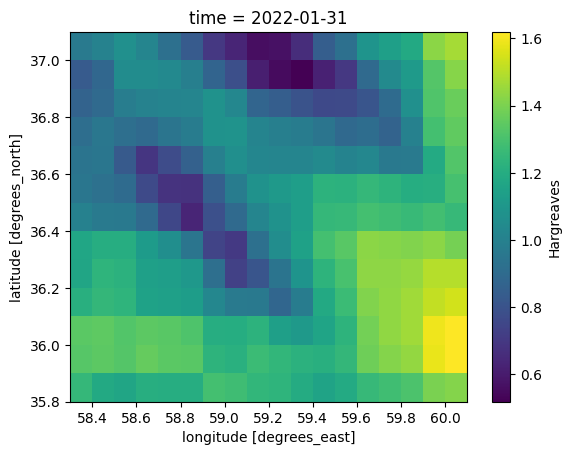

In [23]:
ET_pyet_hargreaves = pyet.combination.hargreaves(
    tmean = tmean.air_temperature,
    tmax = tmax.air_temperature,
    tmin = tmin.air_temperature,
    lat = convert_degrees2radians(tmin.lat)
)
ET_pyet_hargreaves = ET_pyet_hargreaves.to_dataset()
ET_pyet_hargreaves.Hargreaves.plot()

### Estimate  Evapotranspiration (ET)

In [24]:
number_of_x = len(list(ET_pyet_hargreaves.lon.values.flatten()))
number_of_y = len(list(ET_pyet_hargreaves.lat.values.flatten()))

soil_era_evaporation_list = list(xds_repr_match__soil_era_evaporation.volumetric_soil_water_layer_1.values.flatten())
soil_era_transpiration_list = list(xds_repr_match__soil_era_transpiration.volumetric_soil_water_layer_3.values.flatten())
soil_era_transition_list = list(xds_repr_match__soil_era_transition.volumetric_soil_water_layer_4.values.flatten())


wp_list_10cm = list(map(lambda dict: dict['b10'], list_wp))
fc_list_10cm = list(map(lambda dict: dict['b10'], list_fc))
org_list_10cm = list(map(lambda dict: dict['b10'], list_org))
clay_list_10cm = list(map(lambda dict: dict['b10'], list_clay))
sand_list_10cm = list(map(lambda dict: dict['b10'], list_sand))

wp_list_100cm = list(map(lambda dict: dict['b100'], list_wp))
fc_list_100cm = list(map(lambda dict: dict['b100'], list_fc))
org_list_100cm = list(map(lambda dict: dict['b100'], list_org))
clay_list_100cm = list(map(lambda dict: dict['b100'], list_clay))
sand_list_100cm = list(map(lambda dict: dict['b100'], list_sand))

wp_list_200cm = list(map(lambda dict: dict['b200'], list_wp))
fc_list_200cm = list(map(lambda dict: dict['b200'], list_fc))
org_list_200cm = list(map(lambda dict: dict['b200'], list_org))
clay_list_200cm = list(map(lambda dict: dict['b200'], list_clay))
sand_list_200cm = list(map(lambda dict: dict['b200'], list_sand))


ET_hargreaves_list = list(ET_pyet_hargreaves.Hargreaves.values.flatten())



moisture_reduction = list(map(lambda x, y, z: moisture_reduction_function(
    soil_wetness_in_previous_step = x,
    permanent_wilting_point_wet = y,
    field_capacity_wet = z,
    soil_depth = 1000), soil_era_transpiration_list, wp_list_100cm, fc_list_100cm))

moisture_reduction_adjusted = list(map(lambda x: 0 if x < 0 else x, moisture_reduction))



ET_ca = list(map(lambda x, y : ActualEvapotranspiration.et_covered(
    moisture_reduction_function = x,
    crop_coefficient = 0.5,
    crop_cover = 0.4,
    reference_crop_evapotranspiration = y),
    moisture_reduction_adjusted, ET_hargreaves_list))


TE = list(map(lambda x, y : available_water(
    permanent_wilting_point_wet = x,
    field_capacity_wet = y,
    soil_depth = 1000),wp_list_100cm, fc_list_100cm))


AE = 60 ## Assumption

K_e = list(map(lambda x : ratio_of_actual_evaporable_water_to_total_evaporable_water(
    available_water = x,
    available_evaporable_water = AE), TE))

E_a = list(map(lambda x, y : ActualEvapotranspiration.e_noncovered(
    ratio_of_actual_evaporable_water_to_total_evaporable_water = x,
    crop_cover = 0.4,
    reference_crop_evapotranspiration = y), K_e, ET_hargreaves_list))

ET_a = list(map(lambda x, y : ActualEvapotranspiration.et_QDWB(
    evaporation_noncovered_areas = x,
    evapotranspiration_covered_areas = y), E_a, ET_ca))

soil_era_evaporation_list = np.array(soil_era_evaporation_list)
soil_era_transpiration_list = np.array(soil_era_transpiration_list)
soil_era_transition_list = np.array(soil_era_transition_list)
ET_ca_array = np.array(ET_ca)
E_a_array = np.array(E_a)
ET_a_array = np.array(ET_a)
wp_list_10cm_array = np.array(wp_list_10cm)
fc_list_10cm_array = np.array(fc_list_10cm)
wp_list_100cm_array = np.array(wp_list_100cm)
fc_list_100cm_array = np.array(fc_list_100cm)
wp_list_200cm_array = np.array(wp_list_200cm)
fc_list_200cm_array = np.array(fc_list_200cm)
organic_list_10cm_array = np.array(org_list_10cm)
organic_list_100cm_array = np.array(org_list_100cm)
organic_list_200cm_array = np.array(org_list_200cm)
clay_list_10cm_array = np.array(clay_list_10cm)
clay_list_100cm_array = np.array(clay_list_100cm)
clay_list_200cm_array = np.array(clay_list_200cm)
sand_list_10cm_array = np.array(sand_list_10cm)
sand_list_100cm_array = np.array(sand_list_100cm)
sand_list_200cm_array = np.array(sand_list_200cm)

soil_era_evaporation_array = soil_era_evaporation_list.reshape(1,number_of_y,number_of_x)
soil_era_transpiration_array = soil_era_transpiration_list.reshape(1,number_of_y,number_of_x)
soil_era_transition_array = soil_era_transition_list.reshape(1,number_of_y,number_of_x)
ET_ca_array = ET_ca_array.reshape(1,number_of_y,number_of_x)
E_a_array = E_a_array.reshape(1,number_of_y,number_of_x)
ET_a_array = ET_a_array.reshape(1,number_of_y,number_of_x)
wp_list_10cm_array = wp_list_10cm_array.reshape(1,number_of_y,number_of_x)
fc_list_10cm_array = fc_list_10cm_array.reshape(1,number_of_y,number_of_x)
wp_list_100cm_array = wp_list_100cm_array.reshape(1,number_of_y,number_of_x)
fc_list_100cm_array = fc_list_100cm_array.reshape(1,number_of_y,number_of_x)
wp_list_200cm_array = wp_list_200cm_array.reshape(1,number_of_y,number_of_x)
fc_list_200cm_array = fc_list_200cm_array.reshape(1,number_of_y,number_of_x)
organic_list_10cm_array = organic_list_10cm_array.reshape(1,number_of_y,number_of_x)
organic_list_100cm_array = organic_list_100cm_array.reshape(1,number_of_y,number_of_x)
organic_list_200cm_array = organic_list_200cm_array.reshape(1,number_of_y,number_of_x)
clay_list_10cm_array = clay_list_10cm_array.reshape(1,number_of_y,number_of_x)
clay_list_100cm_array = clay_list_100cm_array.reshape(1,number_of_y,number_of_x)
clay_list_200cm_array = clay_list_200cm_array.reshape(1,number_of_y,number_of_x)
sand_list_10cm_array = sand_list_10cm_array.reshape(1,number_of_y,number_of_x)
sand_list_100cm_array = sand_list_100cm_array.reshape(1,number_of_y,number_of_x)
sand_list_200cm_array = sand_list_200cm_array.reshape(1,number_of_y,number_of_x)


ds_array = tmin_renamed.assign(et_covered=(['time', 'y', 'x'], ET_ca_array))
ds_array_1 = ds_array.assign(e_noncovered=(['time', 'y', 'x'], E_a_array))
ds_array_2 = ds_array_1.assign(et_total=(['time', 'y', 'x'], ET_a_array))
ds_array_3 = ds_array_2.assign(wp_10cm=(['time', 'y', 'x'], wp_list_10cm_array))
ds_array_4 = ds_array_3.assign(fc_10cm=(['time', 'y', 'x'], fc_list_10cm_array))
ds_array_5 = ds_array_4.assign(wp_100cm=(['time', 'y', 'x'], wp_list_100cm_array))
ds_array_6 = ds_array_5.assign(fc_100cm=(['time', 'y', 'x'], fc_list_100cm_array))
ds_array_7 = ds_array_6.assign(wp_200cm=(['time', 'y', 'x'], wp_list_200cm_array))
ds_array_8 = ds_array_7.assign(fc_200cm=(['time', 'y', 'x'], fc_list_200cm_array))
ds_array_9 = ds_array_8.assign(organic_10cm=(['time', 'y', 'x'], organic_list_10cm_array))
ds_array_10 = ds_array_9.assign(organic_100cm=(['time', 'y', 'x'], organic_list_100cm_array))
ds_array_11 = ds_array_10.assign(organic_200cm=(['time', 'y', 'x'], organic_list_200cm_array))

ds_array_12 = ds_array_11.assign(clay_10cm=(['time', 'y', 'x'], clay_list_10cm_array))
ds_array_13 = ds_array_12.assign(clay_100cm=(['time', 'y', 'x'], clay_list_100cm_array))
ds_array_14 = ds_array_13.assign(clay_200cm=(['time', 'y', 'x'], clay_list_200cm_array))
ds_array_15 = ds_array_14.assign(sand_10cm=(['time', 'y', 'x'], sand_list_10cm_array))
ds_array_16 = ds_array_15.assign(sand_100cm=(['time', 'y', 'x'], sand_list_100cm_array))
ds_array_17 = ds_array_16.assign(sand_200cm=(['time', 'y', 'x'], sand_list_200cm_array))
ds_array_18 = ds_array_17.assign(swc_era_evaporation=(['time', 'y', 'x'], soil_era_evaporation_array))
ds_array_19 = ds_array_18.assign(swc_era_transpiration=(['time', 'y', 'x'], soil_era_transpiration_array))
ds_array_final = ds_array_19.assign(swc_era_transition=(['time', 'y', 'x'], soil_era_transition_array))

ds_array_final

<xarray.Dataset>
Dimensions:                (x: 18, y: 13, time: 1)
Coordinates:
  * x                      (x) float32 58.35 58.45 58.55 ... 59.85 59.95 60.05
  * y                      (y) float32 37.05 36.95 36.85 ... 36.05 35.95 35.85
  * time                   (time) datetime64[ns] 2022-01-31
    spatial_ref            int64 0
Data variables: (12/22)
    air_temperature        (time, y, x) float32 ...
    et_covered             (time, y, x) float64 0.0 0.0 0.0 ... 8.189e-05 0.0
    e_noncovered           (time, y, x) float64 0.3035 0.3445 ... 0.5188 0.5247
    et_total               (time, y, x) float64 0.3035 0.3445 ... 0.5188 0.5247
    wp_10cm                (time, y, x) float64 17.53 15.74 15.1 ... 13.31 13.31
    fc_10cm                (time, y, x) float64 29.45 26.98 ... 23.47 23.47
    ...                     ...
    sand_10cm              (time, y, x) float64 0.33 0.4 0.41 ... 0.4 0.4 0.46
    sand_100cm             (time, y, x) float64 0.35 0.44 0.42 ... 0.41 0.48
    sand_200cm             (time, y, x) float64 0.37 0.47 0.44 ... 0.43 0.49
    swc_era_evaporation    (time, y, x) float64 21.95 22.47 22.22 ... 8.47 8.413
    swc_era_transpiration  (time, y, x) float64 116.8 121.8 ... 138.7 138.6
    swc_era_transition     (time, y, x) float64 418.3 430.8 ... 399.5 396.4
Attributes:
    history:          Created on 2022-02-06 07:16
    input_data_hash:  a1123a6e0d2788e1883ec8f01cc52110d92449cef4cf1591984fe91...

## Load Data Curve Number

In [25]:
CN_Wyoming =  ee.Image("users/jaafarhadi/GCN250/GCN250Dry").select('b1').rename('dry')

CN_Wyoming = CN_Wyoming.clip(shape)

CN_Wyoming = CN_Wyoming.set("system:time_start", ee.Date("2015"))
arr = CN_Wyoming.wx.to_xarray(scale=250, crs=f'EPSG:{crs}')
xds_repr_match_curve_number = arr.rio.reproject_match(tmin_renamed, resampling = rasterio.enums.Resampling.nearest)

Downloading:   0%|          | 0.00/71.0k [00:00<?, ?iB/s]

# estimate runoff and underground runoff by scs method

## with Variable antecedent_precipitation

In [26]:
data = P.rename({'lon': 'x','lat': 'y'})
data_pre = data.rio.write_crs("epsg:4326", inplace=True)


cn = list(xds_repr_match_curve_number.dry.values.flatten())
pre = list(data_pre.precipitation.values.flatten())


runoff_array = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = float(z),
    is_growing_season = True
)[0]
for i, j, z in zip(pre, cn, soil_era_evaporation_list)])

underground_runoff_array = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = float(z),
    is_growing_season = True
)[1]
for i, j, z in zip(pre, cn, soil_era_evaporation_list)])

cn_array = np.array(cn)


cn_array = cn_array.reshape(1,number_of_y,number_of_x)
runoff_array = runoff_array.reshape(1,number_of_y,number_of_x)
underground_runoff_array = underground_runoff_array.reshape(1,number_of_y,number_of_x)


ds2_array_1 = ds_array_final.assign(runoff=(['time', 'y', 'x'], runoff_array))
ds2_array_2 = ds2_array_1.assign(underground_runoff=(['time', 'y', 'x'], underground_runoff_array))
ds2_array_3 = ds2_array_2.assign(cn_dry=(['time', 'y', 'x'], cn_array))


ds2_array_3



<xarray.Dataset>
Dimensions:                (x: 18, y: 13, time: 1)
Coordinates:
  * x                      (x) float32 58.35 58.45 58.55 ... 59.85 59.95 60.05
  * y                      (y) float32 37.05 36.95 36.85 ... 36.05 35.95 35.85
  * time                   (time) datetime64[ns] 2022-01-31
    spatial_ref            int64 0
Data variables: (12/25)
    air_temperature        (time, y, x) float32 ...
    et_covered             (time, y, x) float64 0.0 0.0 0.0 ... 8.189e-05 0.0
    e_noncovered           (time, y, x) float64 0.3035 0.3445 ... 0.5188 0.5247
    et_total               (time, y, x) float64 0.3035 0.3445 ... 0.5188 0.5247
    wp_10cm                (time, y, x) float64 17.53 15.74 15.1 ... 13.31 13.31
    fc_10cm                (time, y, x) float64 29.45 26.98 ... 23.47 23.47
    ...                     ...
    swc_era_evaporation    (time, y, x) float64 21.95 22.47 22.22 ... 8.47 8.413
    swc_era_transpiration  (time, y, x) float64 116.8 121.8 ... 138.7 138.6
    swc_era_transition     (time, y, x) float64 418.3 430.8 ... 399.5 396.4
    runoff                 (time, y, x) float64 4.233 9.581 ... 21.01 10.08
    underground_runoff     (time, y, x) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    cn_dry                 (time, y, x) float64 75.0 57.0 57.0 ... 59.0 75.0
Attributes:
    history:          Created on 2022-02-06 07:16
    input_data_hash:  a1123a6e0d2788e1883ec8f01cc52110d92449cef4cf1591984fe91...

In [41]:

evapotranspiration_list = list(ds2_array_3.et_covered.values.flatten())
inf_list = list(ds2_array_3.underground_runoff.values.flatten())
evaporation_list = list(ds2_array_3.e_noncovered.values.flatten())

soil_moisture_evaporation_in_current_step_1 = np.array([SoilContent.waterSoilContentCoverd(
    infiltration = float(inf),
    evaporation = float(e),
    transpiration = float(et),
    init_swc_evaporation_layer = float(i),
    init_swc_transition_layer = float(z),
    init_swc_transpiration_layer = float(j),
    z_transpiration_layer = 1000,
    fc_evaporation_layer = float(fc10),
    fc_transition_layer = float(fc200),
    fc_transpiration_layer = float(fc100),
    pwp_evaporation_layer = float(wp10),
    pwp_transition_layer = float(wp200),
    pwp_transpiration_layer = float(wp100),
    stress_coefficient = 0.7,
    MAD = 0.6
)[0]
for i, j, z, et, e, inf, fc10, wp10, fc100, wp100, fc200, wp200 in zip(soil_era_evaporation_list, soil_era_transpiration_list, soil_era_transition_list, evapotranspiration_list, evaporation_list, inf_list, fc_list_10cm, wp_list_10cm, fc_list_100cm, wp_list_100cm, fc_list_200cm, wp_list_200cm)])


soil_moisture_transpiration_in_current_step_1 = np.array([SoilContent.waterSoilContentCoverd(
    infiltration = float(inf),
    evaporation = float(e),
    transpiration = float(et),
    init_swc_evaporation_layer = float(i),
    init_swc_transition_layer = float(z),
    init_swc_transpiration_layer = float(j),
    z_transpiration_layer = 1000,
    fc_evaporation_layer = float(fc10),
    fc_transition_layer = float(fc200),
    fc_transpiration_layer = float(fc100),
    pwp_evaporation_layer = float(wp10),
    pwp_transition_layer = float(wp200),
    pwp_transpiration_layer = float(wp100),
    stress_coefficient = 0.7,
    MAD = 0.6
)[1]
for i, j, z, et, e, inf, fc10, wp10, fc100, wp100, fc200, wp200 in zip(soil_era_evaporation_list, soil_era_transpiration_list, soil_era_transition_list, evapotranspiration_list, evaporation_list, inf_list, fc_list_10cm, wp_list_10cm, fc_list_100cm, wp_list_100cm, fc_list_200cm, wp_list_200cm)])


soil_moisture_transition_in_current_step_1 = np.array([SoilContent.waterSoilContentCoverd(
    infiltration = float(inf),
    evaporation = float(e),
    transpiration = float(et),
    init_swc_evaporation_layer = float(i),
    init_swc_transition_layer = float(z),
    init_swc_transpiration_layer = float(j),
    z_transpiration_layer = 1000,
    fc_evaporation_layer = float(fc10),
    fc_transition_layer = float(fc200),
    fc_transpiration_layer = float(fc100),
    pwp_evaporation_layer = float(wp10),
    pwp_transition_layer = float(wp200),
    pwp_transpiration_layer = float(wp100),
    stress_coefficient = 0.7,
    MAD = 0.6
)[2]
for i, j, z, et, e, inf, fc10, wp10, fc100, wp100, fc200, wp200 in zip(soil_era_evaporation_list, soil_era_transpiration_list, soil_era_transition_list, evapotranspiration_list, evaporation_list, inf_list, fc_list_10cm, wp_list_10cm, fc_list_100cm, wp_list_100cm, fc_list_200cm, wp_list_200cm)])


transpiration_in_current_step_1 = np.array([SoilContent.waterSoilContentCoverd(
    infiltration = float(inf),
    evaporation = float(e),
    transpiration = float(et),
    init_swc_evaporation_layer = float(i),
    init_swc_transition_layer = float(z),
    init_swc_transpiration_layer = float(j),
    z_transpiration_layer = 1000,
    fc_evaporation_layer = float(fc10),
    fc_transition_layer = float(fc200),
    fc_transpiration_layer = float(fc100),
    pwp_evaporation_layer = float(wp10),
    pwp_transition_layer = float(wp200),
    pwp_transpiration_layer = float(wp100),
    stress_coefficient = 0.7,
    MAD = 0.6
)[3]
for i, j, z, et, e, inf, fc10, wp10, fc100, wp100, fc200, wp200 in zip(soil_era_evaporation_list, soil_era_transpiration_list, soil_era_transition_list, evapotranspiration_list, evaporation_list, inf_list, fc_list_10cm, wp_list_10cm, fc_list_100cm, wp_list_100cm, fc_list_200cm, wp_list_200cm)])


evaporation_in_current_step_1 = np.array([SoilContent.waterSoilContentCoverd(
    infiltration = float(inf),
    evaporation = float(e),
    transpiration = float(et),
    init_swc_evaporation_layer = float(i),
    init_swc_transition_layer = float(z),
    init_swc_transpiration_layer = float(j),
    z_transpiration_layer = 1000,
    fc_evaporation_layer = float(fc10),
    fc_transition_layer = float(fc200),
    fc_transpiration_layer = float(fc100),
    pwp_evaporation_layer = float(wp10),
    pwp_transition_layer = float(wp200),
    pwp_transpiration_layer = float(wp100),
    stress_coefficient = 0.7,
    MAD = 0.6
)[4]
for i, j, z, et, e, inf, fc10, wp10, fc100, wp100, fc200, wp200 in zip(soil_era_evaporation_list, soil_era_transpiration_list, soil_era_transition_list, evapotranspiration_list, evaporation_list, inf_list, fc_list_10cm, wp_list_10cm, fc_list_100cm, wp_list_100cm, fc_list_200cm, wp_list_200cm)])

current_evaporation_layer_to_transpiration_layer_in_current_step_1 = np.array([SoilContent.waterSoilContentCoverd(
    infiltration = float(inf),
    evaporation = float(e),
    transpiration = float(et),
    init_swc_evaporation_layer = float(i),
    init_swc_transition_layer = float(z),
    init_swc_transpiration_layer = float(j),
    z_transpiration_layer = 1000,
    fc_evaporation_layer = float(fc10),
    fc_transition_layer = float(fc200),
    fc_transpiration_layer = float(fc100),
    pwp_evaporation_layer = float(wp10),
    pwp_transition_layer = float(wp200),
    pwp_transpiration_layer = float(wp100),
    stress_coefficient = 0.7,
    MAD = 0.6
)[5]
for i, j, z, et, e, inf, fc10, wp10, fc100, wp100, fc200, wp200 in zip(soil_era_evaporation_list, soil_era_transpiration_list, soil_era_transition_list, evapotranspiration_list, evaporation_list, inf_list, fc_list_10cm, wp_list_10cm, fc_list_100cm, wp_list_100cm, fc_list_200cm, wp_list_200cm)])

current_transpiration_layer_to_transition_layer_in_current_step_1 = np.array([SoilContent.waterSoilContentCoverd(
    infiltration = float(inf),
    evaporation = float(e),
    transpiration = float(et),
    init_swc_evaporation_layer = float(i),
    init_swc_transition_layer = float(z),
    init_swc_transpiration_layer = float(j),
    z_transpiration_layer = 1000,
    fc_evaporation_layer = float(fc10),
    fc_transition_layer = float(fc200),
    fc_transpiration_layer = float(fc100),
    pwp_evaporation_layer = float(wp10),
    pwp_transition_layer = float(wp200),
    pwp_transpiration_layer = float(wp100),
    stress_coefficient = 0.7,
    MAD = 0.6
)[6]
for i, j, z, et, e, inf, fc10, wp10, fc100, wp100, fc200, wp200 in zip(soil_era_evaporation_list, soil_era_transpiration_list, soil_era_transition_list, evapotranspiration_list, evaporation_list, inf_list, fc_list_10cm, wp_list_10cm, fc_list_100cm, wp_list_100cm, fc_list_200cm, wp_list_200cm)])

irrigation_requirement_in_current_step_1 = np.array([SoilContent.waterSoilContentCoverd(
    infiltration = float(inf),
    evaporation = float(e),
    transpiration = float(et),
    init_swc_evaporation_layer = float(i),
    init_swc_transition_layer = float(z),
    init_swc_transpiration_layer = float(j),
    z_transpiration_layer = 1000,
    fc_evaporation_layer = float(fc10),
    fc_transition_layer = float(fc200),
    fc_transpiration_layer = float(fc100),
    pwp_evaporation_layer = float(wp10),
    pwp_transition_layer = float(wp200),
    pwp_transpiration_layer = float(wp100),
    stress_coefficient = 0.7,
    MAD = 0.6
)[7]
for i, j, z, et, e, inf, fc10, wp10, fc100, wp100, fc200, wp200 in zip(soil_era_evaporation_list, soil_era_transpiration_list, soil_era_transition_list, evapotranspiration_list, evaporation_list, inf_list, fc_list_10cm, wp_list_10cm, fc_list_100cm, wp_list_100cm, fc_list_200cm, wp_list_200cm)])

deepPercolation_in_current_step_1 = np.array([SoilContent.waterSoilContentCoverd(
    infiltration = float(inf),
    evaporation = float(e),
    transpiration = float(et),
    init_swc_evaporation_layer = float(i),
    init_swc_transition_layer = float(z),
    init_swc_transpiration_layer = float(j),
    z_transpiration_layer = 1000,
    fc_evaporation_layer = float(fc10),
    fc_transition_layer = float(fc200),
    fc_transpiration_layer = float(fc100),
    pwp_evaporation_layer = float(wp10),
    pwp_transition_layer = float(wp200),
    pwp_transpiration_layer = float(wp100),
    stress_coefficient = 0.7,
    MAD = 0.6
)[8]
for i, j, z, et, e, inf, fc10, wp10, fc100, wp100, fc200, wp200 in zip(soil_era_evaporation_list, soil_era_transpiration_list, soil_era_transition_list, evapotranspiration_list, evaporation_list, inf_list, fc_list_10cm, wp_list_10cm, fc_list_100cm, wp_list_100cm, fc_list_200cm, wp_list_200cm)])





soil_moisture_evaporation_in_current_step_1 = soil_moisture_evaporation_in_current_step_1.reshape(1,number_of_y,number_of_x)
soil_moisture_transpiration_in_current_step_1 = soil_moisture_transpiration_in_current_step_1.reshape(1,number_of_y,number_of_x)
soil_moisture_transition_in_current_step_1 = soil_moisture_transition_in_current_step_1.reshape(1,number_of_y,number_of_x)
transpiration_in_current_step_1 = transpiration_in_current_step_1.reshape(1,number_of_y,number_of_x)
evaporation_in_current_step_1 = evaporation_in_current_step_1.reshape(1,number_of_y,number_of_x)
current_evaporation_layer_to_transpiration_layer_in_current_step_1 = current_evaporation_layer_to_transpiration_layer_in_current_step_1.reshape(1,number_of_y,number_of_x)
current_transpiration_layer_to_transition_layer_in_current_step_1 = current_transpiration_layer_to_transition_layer_in_current_step_1.reshape(1,number_of_y,number_of_x)
irrigation_requirement_in_current_step_1 = irrigation_requirement_in_current_step_1.reshape(1,number_of_y,number_of_x)
deepPercolation_in_current_step_1 = deepPercolation_in_current_step_1.reshape(1,number_of_y,number_of_x)



ds2_array_4 = ds2_array_3.assign(soil_moisture_evaporation_in_current_step_1=(['time', 'y', 'x'], soil_moisture_evaporation_in_current_step_1))
ds2_array_5 = ds2_array_4.assign(soil_moisture_transpiration_in_current_step_1=(['time', 'y', 'x'], soil_moisture_transpiration_in_current_step_1))
ds2_array_6 = ds2_array_5.assign(soil_moisture_transition_in_current_step_1=(['time', 'y', 'x'], soil_moisture_transition_in_current_step_1))
ds2_array_7 = ds2_array_6.assign(transpiration_in_current_step_1=(['time', 'y', 'x'], transpiration_in_current_step_1))
ds2_array_8 = ds2_array_7.assign(evaporation_in_current_step_1=(['time', 'y', 'x'], evaporation_in_current_step_1))
ds2_array_9 = ds2_array_8.assign(current_evaporation_layer_to_transpiration_layer_in_current_step_1=(['time', 'y', 'x'], current_evaporation_layer_to_transpiration_layer_in_current_step_1))
ds2_array_10 = ds2_array_9.assign(current_transpiration_layer_to_transition_layer_in_current_step_1=(['time', 'y', 'x'], current_transpiration_layer_to_transition_layer_in_current_step_1))
ds2_array_11 = ds2_array_10.assign(irrigation_requirement_in_current_step_1=(['time', 'y', 'x'], irrigation_requirement_in_current_step_1))
ds2_array_12 = ds2_array_11.assign(deepPercolation_in_current_step_1=(['time', 'y', 'x'], deepPercolation_in_current_step_1))

ds2_array_12

<xarray.Dataset>
Dimensions:                                                             (x: 18,
                                                                         y: 13,
                                                                         time: 1)
Coordinates:
  * x                                                                   (x) float32 ...
  * y                                                                   (y) float32 ...
  * time                                                                (time) datetime64[ns] ...
    spatial_ref                                                         int64 0
Data variables: (12/34)
    air_temperature                                                     (time, y, x) float32 ...
    et_covered                                                          (time, y, x) float64 ...
    e_noncovered                                                        (time, y, x) float64 ...
    et_total                                                            (time, y, x) float64 ...
    wp_10cm                                                             (time, y, x) float64 ...
    fc_10cm                                                             (time, y, x) float64 ...
    ...                                                                  ...
    transpiration_in_current_step_1                                     (time, y, x) float64 ...
    evaporation_in_current_step_1                                       (time, y, x) float64 ...
    current_evaporation_layer_to_transpiration_layer_in_current_step_1  (time, y, x) float64 ...
    current_transpiration_layer_to_transition_layer_in_current_step_1   (time, y, x) float64 ...
    irrigation_requirement_in_current_step_1                            (time, y, x) float64 ...
    deepPercolation_in_current_step_1                                   (time, y, x) float64 ...
Attributes:
    history:          Created on 2022-02-06 07:16
    input_data_hash:  a1123a6e0d2788e1883ec8f01cc52110d92449cef4cf1591984fe91...

In [52]:

with open('/content/drive/MyDrive/WaterBalance_new/notebook/bilan_for_Jan31_2022.pkl', 'wb') as f:  # open a text file
    pickle.dump(ds2_array_12, f) # serialize the list

